Scenario Details:

You have daily closing price data for Stock A and Stock B over the past year (252 trading days).
The spread is defined as: Spread = Price_A - β * Price_B, where β is the hedge ratio (calculated via linear regression).
You’ll assume the spread follows a mean-reverting process.
Entry signal: Buy the spread (long Stock A, short Stock B) when it’s 2 standard deviations below the mean; sell the spread (short Stock A, long Stock B) when it’s 2 standard deviations above the mean.
Exit signal: Close the position when the spread crosses back to within 0.5 standard deviations of the mean.
Transaction costs are 0.1% per trade.

Tasks for You to Solve:
1. Download or simulate realistic price data for two correlated stocks (e.g., use pandas or yfinance to fetch data like Coca-Cola (KO) and PepsiCo (PEP)).
2. Calculate the hedge ratio (β) using linear regression between the two stock prices.
3. Compute the daily spread and its rolling mean and standard deviation (e.g., 20-day window).
4. Identify entry and exit points based on the rules above.
5. Simulate the trades and calculate the total profit/loss, accounting for transaction costs.
6. Assess the strategy’s performance (e.g., total return, number of trades, win/loss ratio).


In [2]:
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt

Initial_Capital = 100_000
Stocks = ['KO','PEP']
df = yf.download(Stocks, start = "2014-01-01", end = "2024-01-01")['Close']
print(f"Before cleaning: {df[Stocks[1]].isna().sum()} NaNs in {Stocks[1]}")
df = df.dropna()
print(f"After cleaning: {len(df)} rows remaining")


# Stationary (Individual Stocks)
def Stationary (x):
    Result = adfuller(x)

    if Result[1] <= 0.05:
        print(f"❌ {x.name} : Stationary (p-value : {Result[1]:.4f})")
    else:
        print(f"✅ {x.name} : Non-Stationary (p-value : {Result[1]:.4f})")

Stationary (df[Stocks[0]])
Stationary (df[Stocks[1]])

# Cointegrated (OLS Regression)
Static_Model = sm.OLS(df[Stocks[0]],sm.add_constant(df[Stocks[1]])).fit()
Static_Hedge_Ratio = Static_Model.params[Stocks[1]]
df['Residual']= Static_Model.resid

if adfuller(df['Residual'])[1] <= 0.05:
    print (f"✅ Stocks are Cointegrated | Hedge Ratio : {Static_Hedge_Ratio: .2f} | (p-value :{adfuller(df['Residual'])[1]:.4f})")
else:
    print (f"❌ Stocks are Not Cointegrated | (p-value :{adfuller(df['Residual'])[1]:.4f})")

# Rolling Model
Rolling_Window = 100
df['Rolling_Hedge_Ratio'] = 0.0

for i in range (Rolling_Window, len(df)):
    Rolling_Model = sm.OLS(df[Stocks[0]].iloc[i-Rolling_Window:i],sm.add_constant(df[Stocks[1]].iloc[i-Rolling_Window:i])).fit()
    df.at[df.index[i],'Rolling_Hedge_Ratio'] = Rolling_Model.params[Stocks[1]]


df['Spread'] = df[Stocks[0]] - df['Rolling_Hedge_Ratio'] * df[Stocks[1]]
print("")

# Trade Logic 
df['Z_Score'] = (df['Spread']-df['Spread'].rolling(window=100).mean()) / (df['Spread'].rolling(window=100).std())

Entry_Signal = 2
TP_Signal = 0.5
SL_Signal = 0.03
Transaction_Cost = 0.001
Open_Position = 0
Entry_Spread = None
Entry_Z_Score = None
df['Signal'] = 0
df['PNL'] = 0.0 

for i in range (Rolling_Window, len(df)):
    Current_Spread = df['Spread'].iloc[i]
    Stock0_Price = df[Stocks[0]].iloc[i]
    Stock1_Price = df[Stocks[1]].iloc[i]

    if Open_Position == 0 :
        if df['Z_Score'].iloc[i] <= -Entry_Signal:
            df.at[df.index[i],'Signal'] = 1 #Long
            Entry_Spread = Current_Spread
            Entry_Stock0 = Stock0_Price
            Entry_Stock1 = Stock1_Price
            Entry_Z_Score = df['Z_Score'].iloc[i]
            Open_Position = 1
            print(f"🟢 Enter LONG Spread at {Entry_Spread:.2f} on {df.index[i].date()} " 
                  f" | {Stocks[0]} : {Stock0_Price:.2f} | {Stocks[1]}: {Stock1_Price: .2f} | Z Score : {df['Z_Score'].iloc[i]:.2f}")

        elif df['Z_Score'].iloc[i] >= Entry_Signal:
            df.at[df.index[i],'Signal'] = -1 #Short
            Entry_Spread = Current_Spread
            Entry_Stock0 = Stock0_Price
            Entry_Stock1 = Stock1_Price
            Entry_Z_Score = df['Z_Score'].iloc[i]
            Open_Position = -1
            print(f"🔴 Enter SHORT Spread at {Entry_Spread:.2f} on {df.index[i].date()} " 
                  f" | {Stocks[0]} : {Stock0_Price:.2f} | {Stocks[1]}: {Stock1_Price: .2f} | Z Score : {df['Z_Score'].iloc[i]:.2f}")

    elif Open_Position != 0:
        Spread_PNL = (Stock0_Price - Entry_Stock0) - df['Rolling_Hedge_Ratio'].iloc[i] * (Stock1_Price - Entry_Stock1)
        if Open_Position == -1:
            Spread_PNL = - Spread_PNL

        Position_value = abs(Spread_PNL)
        Stop_Loss = Initial_Capital*SL_Signal


        if  (Open_Position == 1 and df['Z_Score'].iloc[i] > -TP_Signal) or \
            (Open_Position == -1 and df['Z_Score'].iloc[i] < TP_Signal) or \
            (Position_value >= Stop_Loss ):
            Cost = Transaction_Cost * (Stock0_Price + df['Rolling_Hedge_Ratio'].iloc[i]*Stock1_Price) * 2
            Net_PNL = Spread_PNL - Cost

            df.at[df.index[i], 'PNL'] = Net_PNL
            print(f"🚀 EXIT trade at {Current_Spread:.2f} on {df.index[i].date()} " 
                  f"| {Stocks[0]}: {Stock0_Price:.2f}, {Stocks[1]}: {Stock1_Price:.2f} | PNL: {Net_PNL:.2f} "
                  f"| Z Score : {df['Z_Score'].iloc[i]:.2f}")
            Open_Position = 0
            Entry_Spread = None
            Entry_Z_Score = None
            df.at[df.index[i], 'Signal'] = 0

# Strategy Performance
Sharpe_Ratio = (df['PNL'].mean()/df['PNL'].std())*np.sqrt(252)
df['Equity'] = Initial_Capital + df['PNL'].cumsum()
df['DrawDown_%'] = (((df['Equity'] / df['Equity'].cummax())-1) *100)


print(f"\nFinal PNL : {df['PNL'].cumsum().iloc[-1]:.2f} "
      f"| Sharpe Ratio : {Sharpe_Ratio:.2f} "
      f"| Max DD : {df['DrawDown_%'].min():.2f}% "
      f"| WinRate : {(df['PNL'] > 0).sum() / (((df['PNL']!=0).sum()))*100:.2f}%")
#df.to_csv (r"..\Backtested_Results.csv", index=True)


[*********************100%***********************]  2 of 2 completed


Before cleaning: 0 NaNs in PEP
After cleaning: 2516 rows remaining
✅ KO : Non-Stationary (p-value : 0.7683)
✅ PEP : Non-Stationary (p-value : 0.8333)
✅ Stocks are Cointegrated | Hedge Ratio :  0.28 | (p-value :0.0005)

🟢 Enter LONG Spread at 2.77 on 2014-05-28  | KO : 28.89 | PEP:  63.73 | Z Score : -9.32
🚀 EXIT trade at 9.41 on 2014-08-14 | KO: 28.83, PEP: 67.69 | PNL: -1.30 | Z Score : -0.40
🔴 Enter SHORT Spread at 21.21 on 2015-02-27  | KO : 31.51 | PEP:  73.99 | Z Score : 2.06
🚀 EXIT trade at 13.62 on 2015-03-10 | KO: 29.61, PEP: 71.06 | PNL: 1.15 | Z Score : 0.30
🟢 Enter LONG Spread at 2.43 on 2015-03-17  | KO : 29.72 | PEP:  70.84 | Z Score : -2.04
🚀 EXIT trade at 7.92 on 2015-04-27 | KO: 29.96, PEP: 71.11 | PNL: 0.05 | Z Score : -0.25
🔴 Enter SHORT Spread at 4.30 on 2016-02-11  | KO : 31.89 | PEP:  74.55 | Z Score : 2.08
🚀 EXIT trade at 5.35 on 2016-03-21 | KO: 34.60, PEP: 78.68 | PNL: -1.31 | Z Score : 0.37
🟢 Enter LONG Spread at -9.87 on 2016-03-31  | KO : 35.15 | PEP:  79.40 

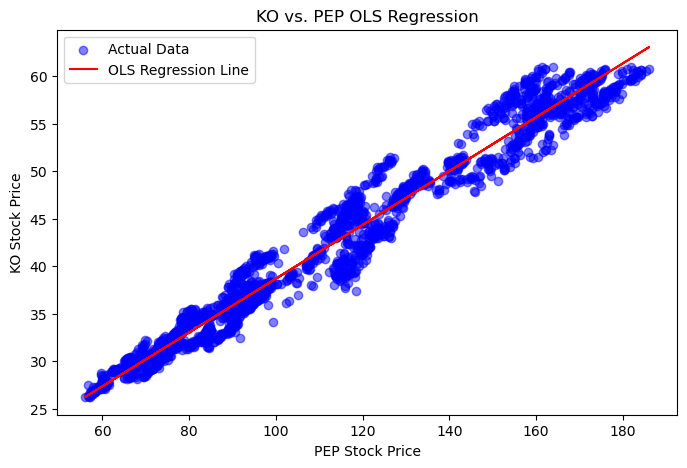

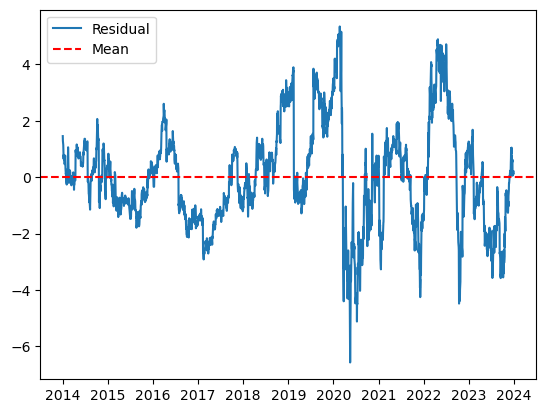

In [3]:
plt.figure(figsize=(8, 5))

# Scatter plot of KO vs. PEP
plt.scatter(df[Stocks[1]], df[Stocks[0]], label="Actual Data", color="blue", alpha=0.5)

# Plot regression line directly from model coefficients
b0, b1 = Static_Model.params  # Extract intercept and slope
plt.plot(df[Stocks[1]], b0 + b1 * df[Stocks[1]], label="OLS Regression Line", color="red")

plt.xlabel("PEP Stock Price")
plt.ylabel(f"{Stocks[0]} Stock Price")
plt.title(f"{Stocks[0]} vs. {Stocks[1]} OLS Regression")
plt.legend()
plt.show()

plt.plot(df['Residual'], label='Residual')
plt.axhline(df['Residual'].mean(), color='r', linestyle='--', label='Mean')
plt.legend()
plt.show()